In [1]:
from util.gen_utils import *
from util.qc_util import *
from util.qpcr_utils import *

import os

%matplotlib inline

%load_ext autoreload
%autoreload 2

# Load raw data
* Discovery = RNAseq
* Validation = RT-qPCR

In [2]:
#Discovery data
discovery_data  = {'rnaseq' : rnaseq_data(counts_df_path = '../../data/rnaseq_discovery_data/htseq_merged.csv'),
              'sample_meta' : read_sample_meta_table('../../data/rnaseq_discovery_data/init_sample_data.csv'),
              'subj_meta' : read_sample_meta_table('../../data/rnaseq_discovery_data/init_subj_data.csv'),
             }

In [3]:
# Validation data

# Load qPCR info
qpcr_info_path = '../../data/rtqpcr_validation_data/plate_maps_qpcr.xlsx'
qpcr_cntrl_name = 'rt_gdna'
qpcr_cntrl_run = "../../data/rtqpcr_validation_data/qpcrs/" + qpcr_cntrl_name + " -  Quantification Cq Results.xlsx"

qpcr_info = {'sample_replicate_map' : read_plate_map(qpcr_info_path, 'sample_replicates_map', to_melt = True, val_name = 'sample'),
            'target_map' : read_plate_map(qpcr_info_path, 'gene_targets_map', to_melt = True, val_name = 'which_target'),
            'standard_curve_map' : read_plate_map(qpcr_info_path, 'standard_curve_map', to_melt = True, val_name = 'sample'),
            'target_info' : read_plate_map(qpcr_info_path, 'gene_targets_loc', to_melt = False, index_col = 1)}

qpcr_cntrl_run = {target_plate : qpcr_cntrl_run for target_plate in qpcr_info['target_info'].plate.str.lower().unique() if target_plate == qpcr_cntrl_name}

validation_data  = {'rt-qpcr': rt_qpcr_data(plate_paths_dict = qpcr_cntrl_run,
                                            plate_map = qpcr_info['sample_replicate_map'],
                                            target_map = qpcr_info['target_map'],
                                            target_info = qpcr_info['target_info'].loc[qpcr_info['target_info'].plate.str.lower() == qpcr_cntrl_name],
                                            has_RT_control = True, NTC_gen_threshold = 35
                                           ),
                    'sample_meta' : read_sample_meta_table('../../data/rnaseq_validation_data/val_sample_data.csv'),
                    'subj_meta' : read_sample_meta_table('../../data/rnaseq_validation_data/val_subj_data.csv')
                   }

# ID outlier samples
* For RNAseq - Based on QC metrics
    * QC measures:
        1. Sample degradation
        2. Ribosomal fraction of reads
        3. Possible DNA contamination (DNAse used but regardless)
* For RT-qPCR - Must pass gDNA control [no genomic DNA] and RT control [reverse transcription control]

In [4]:
#Discovery QC
os.system('python util/id_outliers.py "../../data/qc_data/discovery_ribo_frac.txt" "../../data/qc_data/discovery_deg_3prime_bias_frac_1.txt" "../../data/qc_data/discovery_intron_exon_ratios.txt" \
          "out/discovery_qc/" --cutoffs_file "util/outlier_cutoffs_percentile95.txt"')

discovery_data['qc'] = read_qc_data("out/discovery_qc/outlier_data.txt")

In [5]:
#Validation QC
validation_data['qc'] = pd.DataFrame(columns = ['Outlier'], index = validation_data['sample_meta'].index, dtype = bool)
validation_data['qc'].loc[:, 'Outlier'] = True

validation_data['rt-qpcr'].filter_qPCR() #Note that we expect gDNA to not be detected so 40% below isnt bad since it includes gDNA QC
samples_pass_rtqpcr_qc = validation_data['rt-qpcr'].qPCR.index.drop_duplicates().get_level_values('sample')
validation_data['qc'].loc[samples_pass_rtqpcr_qc.intersection(validation_data['qc'].index), 'Outlier'] = False

print('gDNA detected in %d samples' % (validation_data['rt-qpcr'].qPCR.index.get_level_values('gene_target') == 'gDNA').sum())

50 of 124 (0.40) sample gene measurements were measured consistently at a Cq below the NTC threshold
gDNA detected in 0 samples


# Visualize QC data 
For RNAseq
* Use heatmap to visualize whether outlier samples cluster separately
* Use PCA to visualize logCPM values pre and post outlier sample filtering

# Get cohort stats pre and post QC
* How many people were recruited to participate [Both discovery and validation]?
* Of those, how many were included in the study post QC [Both discovery and validation]?

Discovery dataset
7041 genes (Fraction = 0.115968) passed cutoff
118 samples (0.71) passed QC


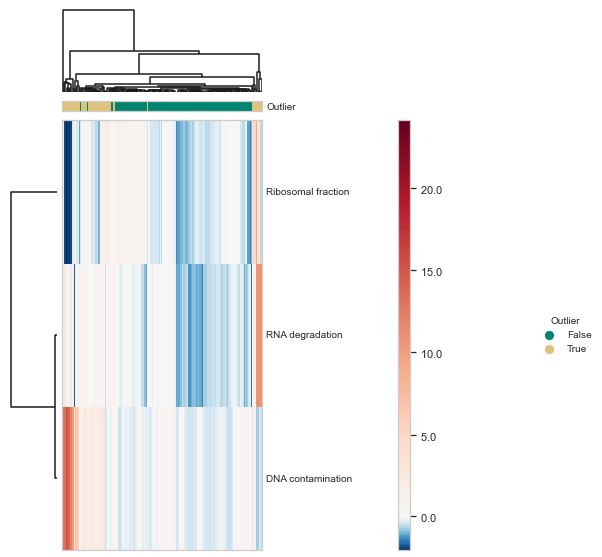

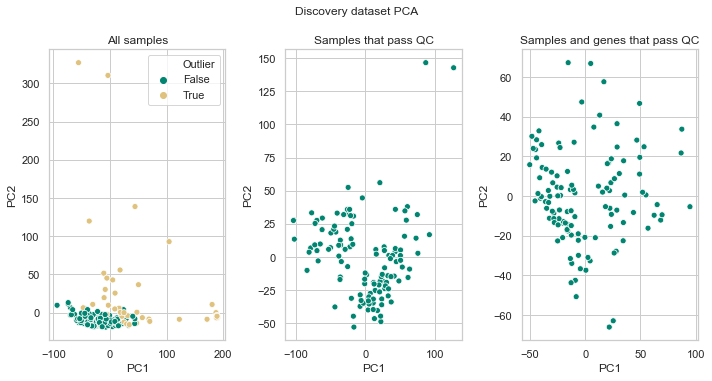

In [6]:
qc_out = {}
cohort_stats = {}
for dataset, data_tuple in {'Discovery dataset' : ('RNAseq', discovery_data, "out/discovery_qc/plots/"),
                           'Validation dataset' : ('RT-qPCR', validation_data, "out/discovery_qc/plots/")}.items():
    
    data_type, data, plot_save_path = data_tuple
    frac_samples_exp_cutoff = 0.75 
    qc_out[dataset] = {}
    
    qc_out[dataset]['samples_passed_qc'] = data['qc'].loc[~(data['qc'].Outlier)].index
    #Cohort stats, Tuple (Pre, Post)
    cohort_stats[dataset] = (data['sample_meta'].drop_duplicates(subset = 'subject').groupby('is_pe').count().iloc[:, 0].to_numpy(), #NP array 0 = NT, 1 = PE
                             data['sample_meta'].loc[qc_out[dataset]['samples_passed_qc']].drop_duplicates(subset = 'subject').groupby('is_pe').count().iloc[:, 0].to_numpy())
    
    #After this point, RNAseq specific QC
    if data_type != 'RNAseq':
        continue
        
    print(dataset)
    qc_out[dataset]['gene_qc_mask'] = filter_genes_CPMcutoff(data['rnaseq'].CPM.loc[:, qc_out[dataset]['samples_passed_qc']], CPM_cutoff = 0.5, frac_samples_exp = frac_samples_exp_cutoff)
    qc_out[dataset]['heatmap'], qc_out[dataset]['pca'] = pca_and_viz_qc(data['qc'], data['rnaseq'].logCPM, qc_out[dataset]['gene_qc_mask'], dataset + " PCA")
    
    save_figure_pdf(qc_out[dataset]['heatmap'], plot_save_path + "heatmap.pdf")
    save_figure_pdf(qc_out[dataset]['pca'], plot_save_path + "pca.pdf")

In [7]:
total_recruited = None
total_included = None

for dataset, cohort_stats_tuple in cohort_stats.items():
    total_recruited = total_recruited + cohort_stats_tuple[0] if total_recruited is not None else cohort_stats_tuple[0]
    total_included = total_included + cohort_stats_tuple[1] if total_included is not None else cohort_stats_tuple[1]
    
    print(dataset)
    print('%d (%d Normotensive, %d PE) people recruited (Pre QC)' % (cohort_stats_tuple[0].sum(), cohort_stats_tuple[0][0], cohort_stats_tuple[0][1]))
    print('%d (%d Normotensive, %d PE) people included (Post QC)' % (cohort_stats_tuple[1].sum(), cohort_stats_tuple[1][0], cohort_stats_tuple[1][1]))
    print()

print('Total = Discovery + Validation')
print('%d (%d Normotensive, %d PE) people recruited (Pre QC)' % (total_recruited.sum(), total_recruited[0], total_recruited[1]))
print('%d (%d Normotensive, %d PE) people included (Post QC)' % (total_included.sum(), total_included[0], total_included[1]))

Discovery dataset
49 (20 Normotensive, 29 PE) people recruited (Pre QC)
42 (18 Normotensive, 24 PE) people included (Post QC)

Validation dataset
17 (8 Normotensive, 9 PE) people recruited (Pre QC)
15 (8 Normotensive, 7 PE) people included (Post QC)

Total = Discovery + Validation
66 (28 Normotensive, 38 PE) people recruited (Pre QC)
57 (26 Normotensive, 31 PE) people included (Post QC)


# Filter data based on QC and save clean data
* Add term column: Split into time groups based on gestational age sampling scheme 
    * Groups are approx based on trimesters; however, scheduling can sometimes result in 2 samples in the same term but weeks apart.
    * Split below tries to keep samples within same 1-2 month period 
* Add PE type: Early vs late as defined by 34 week cutoff
* Adjust PP time definition
    * Post-partum samples should not be defined on GA time. Since they are collected following delivery, should be defined as weeks post delivery
* Remove samples and genes that failed QC from counts tables and save clean table
    * Will use these to estimate TMM normalization and for analysis here on out
* Remove samples that failed QC from metadata tables, combine tables, and save
    * Will use these for analysis here on out

In [8]:
for dataset, data_tuple in {'Discovery dataset' : ('RNAseq', discovery_data, "../../data/rnaseq_discovery_data/"), 
                                      'Validation dataset' : ('RT-qPCR', validation_data, "../../data/rnaseq_validation_data/")}.items():
    
    data_type, data, save_path = data_tuple
    
    print(dataset)
    #Get term data, get early v late onset
    data['sample_meta'].insert(0, 'term', get_term_labels(data['sample_meta'], 'ga_at_collection'))
    
    #Join sample + subj meta, add PE type
    data['sample_meta_full'] = data['sample_meta'].join(data['subj_meta'], on = 'subject', how = 'inner')
    data['sample_meta_full'].insert(data['sample_meta_full'].shape[1], 'pe_type', get_pe_type(data['sample_meta_full']))
    
    #Adjust PP sample collction [should not be on GA time]
    pp_mask = (data['sample_meta_full'].is_pp == 1)
    data['sample_meta_full'].insert(data['sample_meta_full'].shape[1], 'weeks_post_del', np.nan)
    data['sample_meta_full'].loc[pp_mask, 'weeks_post_del'] = data['sample_meta_full'].loc[pp_mask, 'ga_at_collection'] -  data['sample_meta_full'].loc[pp_mask, 'ga_wk_del']
    data['sample_meta_full'].loc[pp_mask, 'ga_at_collection'] = np.nan
    
    #Save pre QC
    data['sample_meta_full'].to_csv(save_path + 'sample_meta_all_merged.csv')
    
    #Remove samples failed QC, 
    data['sample_meta_full'] = data['sample_meta_full'].loc[qc_out[dataset]['samples_passed_qc']]
    
    #Save post QC
    data['sample_meta_full'].to_csv(save_path + 'sample_meta_postQC.csv')
    
    #Print quick stats about data
    print(data['sample_meta_full'].groupby(['group', 'term']).count().iloc[:, 0])
    
    if data_type == 'RNAseq':
        #Clean up counts table
        counts_clean = data['rnaseq'].counts.loc[qc_out[dataset]['gene_qc_mask'], qc_out[dataset]['samples_passed_qc']]
        print('Counts table now has %d genes and %d samples' % counts_clean.shape)
        counts_clean.to_csv(save_path + 'htseq_postQC.csv')

Discovery dataset
group    term
Control  1       14
         2       15
         3       12
         4       14
PE       1       13
         2       15
         3       19
         4       16
Name: subject, dtype: int64
Counts table now has 7041 genes and 118 samples
Validation dataset
group    term
Control  1        6
         2       10
PE       1        5
         2        8
Name: subject, dtype: int64


# Preprocess independent datasets
* Pull out counts and metadata in form that is compatible with fxns used to load RNAseq data and metadata

In [9]:
#Delvecchio et al 2020
delvecchio_sample_meta = read_save_delvecchio_meta(biosample_results_path = '../../data/delvecchio_data/biosample_result.txt', 
                                                   sra_results_path = '../../data/delvecchio_data/SraRunTable.txt',
                                                  out_path = "../../data/delvecchio_data/sample_meta.csv")
delvecchio_sample_meta.head()

,subj_id,sample_type,BioSample,complication_during_pregnancy,term,case
sample,,,,,,
SRR12214516,Normal_Pregnancy_Patient_2,delivery,SAMN15523937,No Complications,NaN,0
SRR12214515,Normal_Pregnancy_Patient_2,3rd_Trimester,SAMN15523938,No Complications,3.0,0
SRR12214514,Normal_Pregnancy_Patient_2,2nd_Trimester,SAMN15523939,No Complications,2.0,0
SRR12214513,Normal_Pregnancy_Patient_2,1st_Trimester,SAMN15523940,No Complications,1.0,0
SRR12214512,Normal_Pregnancy_Patient_1,cord_blood,SAMN15523941,No Complications,NaN,0


In [10]:
#Munchel et al 2020, S1 - PEARL healthy pregnancy data 
munchel_s1_meta = read_save_munchel_data(filepath = '../../data/munchel_data/aaz0131_Data_file_S1.xlsx', 
                                         cnts_out_path = '../../data/munchel_data/S1_counts_only.csv', 
                                         meta_out_path = '../../data/munchel_data/S1_meta.csv', 
                                         mult_samples_per_person = True, is_all_nt = True)
munchel_s1_meta.head()

,ga_at_collection,term,subject,pe_type,case
AA,11.9,1,AA,CTRL,0
D,11.9,1,D,CTRL,0
Q,11.9,1,Q,CTRL,0
H,12.0,1,H,CTRL,0
X,12.1,1,X,CTRL,0


In [11]:
#Munchel et al 2020, S2 - iPEC - early onset PE dataset at diagnosis 
munchel_s2_meta = read_save_munchel_data(filepath = '../../data/munchel_data/aaz0131_Data_file_S2.xlsx', 
                                         cnts_out_path = '../../data/munchel_data/S2_counts_only.csv', 
                                         meta_out_path = '../../data/munchel_data/S2_meta.csv', 
                                         mult_samples_per_person = False, is_all_nt = False)
munchel_s2_meta.head()

,ga_at_collection,term,subject,pe_type,case
PE,30.7,3,PE,PE,1
PE.1,31.7,3,PE.1,PE,1
PE.2,32.0,3,PE.2,PE,1
CTRL,33.3,3,CTRL,CTRL,0
PE.3,33.1,3,PE.3,PE,1


In [ ]:
#Munchel et al 2020, S3 - PEARL-PEC - early and late onset PE dataset at diagnosis
munchel_s3_meta = read_save_munchel_data(filepath = '../../data/munchel_data/aaz0131_Data_file_S3.xlsx', 
                                         cnts_out_path = '../../data/munchel_data/S3_counts_only.csv', 
                                         meta_out_path = '../../data/munchel_data/S3_meta.csv', 
                                         mult_samples_per_person = False, is_all_nt = False)
munchel_s3_meta.head()